### Installing dependencies
This field can be run to check if all dependencies needed for code compilation are correctly installed

In [3]:
%pip install tensorflow tensorflow-gpu opencv-python matplotlib numpy 

^C
Note: you may need to restart the kernel to use updated packages.


### Importing dependencies

In [1]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt, os, cv2, keras, time, sklearn
from tensorflow import keras
from keras.utils import np_utils
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, MaxPooling2D
from keras.models import Model
from keras.models import Sequential
from keras import applications
from keras.optimizers import SGD
from sklearn.metrics import average_precision_score
from keras.metrics import Precision, Recall, BinaryAccuracy
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

### Preprocessing Data

1. Looping through our parasitized and uninfected images in the malaria directory and reading each image with opencv

2. Resizing the image with opencv and turning it into a numpy array

3. Normalizing the numpy array into floating point numbers for processing

4. Appending the numpy array into a regular array and then subsequently turning that array into a numpy array

5. We then show some basic information about our data

In [3]:
num_of_train_samples = 10000
num_of_valid_samples = 5000

data = "../../Dependencies/malaria/malaria-nih/nih-malaria/"
training_data = "../../Dependencies/malaria/malaria-nih/nih-malaria/parasitized/"
validation_data = "../../Dependencies/malaria/malaria-nih/nih-malaria/uninfected/"
vgg_data = "../../Dependencies/malaria/malaria-nih/vgg"
labels = os.listdir(data)

count, null_count, count_val, null_count_val = 0,0,0,0
images = []
images_val = []

y_images_train = np.zeros((num_of_train_samples), dtype='uint8')
y_images_valid = np.zeros((num_of_valid_samples),dtype='uint8')


def preprocess_data():
    print("Loading training data from: {}".format(os.listdir(data)))
    for file in os.listdir(os.path.join(training_data)):
        if count < num_of_train_samples:
            try:
                img_path = os.path.join(os.path.join(training_data, file))            
                image = cv2.imread(img_path, cv2.IMREAD_COLOR)
                image = cv2.resize(image, (100, 100)) 
                image = np.asarray(image, dtype="f") / 255.0
                images += [image]
                y_images_train[count] = null_count
                
                if count % 2500 == 0:
                    print('Done: {0} images out of {1} in {2}'.format(count, num_of_train_samples, "parasitized"))
                count += 1
            except Exception as e:
                continue
            null_count += 1
        else:
            break
        
    for file in os.listdir(os.path.join(validation_data)):
        if count_val < num_of_valid_samples:
            try:
                img_path = os.path.join(os.path.join(validation_data, file))
                image = cv2.imread(img_path, cv2.IMREAD_COLOR)
                image = cv2.resize(image, (100, 100)) 
                image = np.asarray(image, dtype="f") / 255.0
                images_val += [image]
                y_images_valid[count_val] = null_count_val
                
                if count_val % 2500 == 0:
                    print('Done: {0} images out of {1} in {2}'.format(count_val, num_of_valid_samples, "uninfected"))
                count_val += 1
            except Exception as e:
                continue
            null_count_val += 1
        else:
            break
        
    x_images_train = np.array(images)
    x_images_valid = np.array(images_val)
    y_images_train = np.expand_dims(y_images_train, axis=1)
    y_images_valid = np.expand_dims(y_images_valid, axis=1)
    y_images_train = np_utils.to_categorical(y_images_train[:num_of_train_samples], 0)
    y_images_valid = np_utils.to_categorical(y_images_valid[:num_of_valid_samples], 0)


    x_mean = np.mean(x_images_train)

    print('\nEstimated number of training samples: {0}\nEstimated number of validation samples: {1}'.format(num_of_train_samples, num_of_valid_samples))
    print("{0} of training images loaded. \n{1} of validation images loaded. \n".format(len(x_images_train), len(x_images_valid)))
    print("Training image array has shape: ", x_images_train.shape, "\nValidation image array has shape: ", x_images_valid.shape)
    print("Training image label array has shape: ", y_images_train.shape, "\nValidation image label array has shape: ", y_images_valid.shape, "\n")
    print("Training image array mean: {0}\n".format(x_mean))

    # np.save('malaria/numpydata/x_training_data.npy', x_images_train)  
    # np.save('malaria/numpydata/y_training_data.npy', y_images_train)   
    # np.save('malaria/numpydata/x_validation_data.npy', x_images_valid)
    # np.save('malaria/numpydata/y_validation_data.npy', y_images_valid)

keras_compatible_pipeline = keras.utils.image_dataset_from_directory(data, image_size=(100,100))

Found 27558 files belonging to 2 classes.


### Processing the data

- Normalizing the data into floating point values between 0-1
- Batching the keras compatible data into training, validation and testing batches for the ML model
- We use 500 batches of training data, 262 batches of validation data and 100 batches of testing data

- 500 batches training = 16,000
- 262 validation batches = 8,384
- 100 testing batches = 3,200

In [4]:
keras_compatible_pipeline = keras_compatible_pipeline.map(lambda x, y: (x / 255.0, y))

train_data = keras_compatible_pipeline.take(500)
validation_data = keras_compatible_pipeline.skip(500).take(262)
testing_data = keras_compatible_pipeline.skip(750).take(100)

vgg_test_datagen = ImageDataGenerator(rescale = 1./255)
vgg_test_set = vgg_test_datagen.flow_from_directory(vgg_data, target_size = (224, 224), batch_size = 32, shuffle=False, class_mode='binary')
vgg_test_labels = vgg_test_set.classes

# np.save('../../malaria/numpydata/vgg_testing_data', vgg_test_set)

Found 15000 images belonging to 2 classes.


## Building and applying the ML model

In this section we initialize different machine learning models and compare the accuracy and make predictions on data

### VGG16 Very Deep Convolutional Network for Large-Scale Image Recognition

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

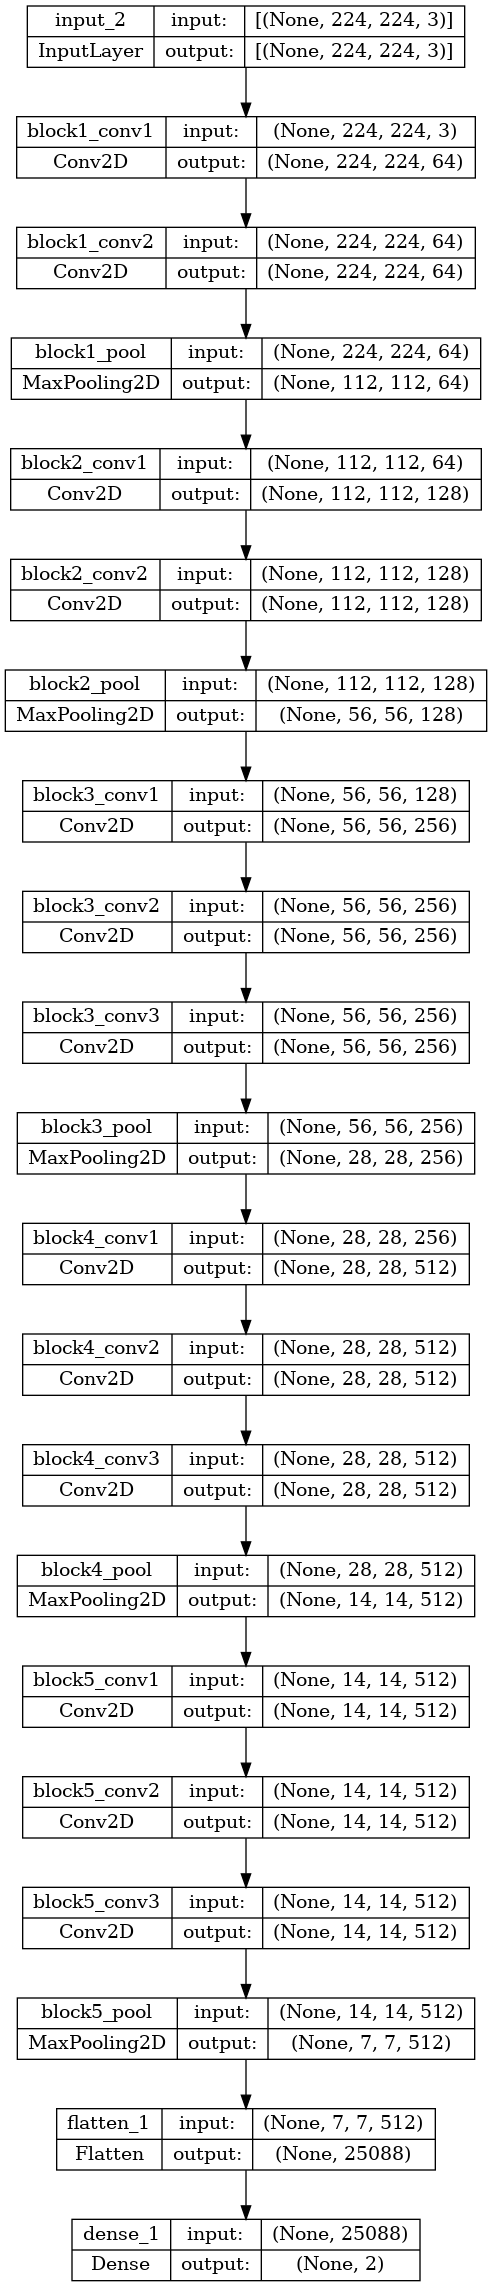

In [3]:
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, MaxPooling2D, Input, Lambda
from keras.models import Model
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Sequential

vgg = VGG16(input_shape=[224,224] + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
    
x = Flatten()(vgg.output)
prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True, to_file='VGG16_model.png') #to visualize the model

### Keras Sequential Model 

In [7]:
model = Sequential()

model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(100, 100, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True, to_file='horizontal_model.jpg',rankdir='LR') #to visualize the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 16)       0

### Keras Sequential 2.0

In [8]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Multiply
from keras.layers import GlobalAveragePooling2D, Reshape
from keras.models import Model
from keras import backend as K

def spatial_attention(input_feature_map):
    """
    Spatial Attention mechanism function to focus on specific parts of the image
    """
    # Global Average Pooling
    avg_pool = GlobalAveragePooling2D()(input_feature_map)

    # Reshape to (batch_size, channels)
    reshaped = Reshape((1, 1, input_feature_map.shape[3]))(avg_pool)

    # Convolution with 1x1 filters and 'sigmoid' activation
    conv = Conv2D(filters=1, kernel_size=1, activation='sigmoid')(reshaped)

    # Element-wise multiplication between input feature map and attention map
    multiplied = Multiply()([input_feature_map, conv])

    return multiplied

# Define the model architecture
inputs = Input(shape=(100, 100, 3))
conv1 = Conv2D(32, (3, 3), activation='relu')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu')(pool2)

# Spatial Attention Mechanism
attention = spatial_attention(conv3)
dense = Dense(256, activation='relu')(Flatten()(attention))
dropout = Dropout(0.5)(dense)

dense2 = Dense(1, activation='sigmoid')(dropout)

# Final output
model = Model(inputs=inputs, outputs=dense2)
model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 98, 98, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 49, 49, 32)  0           ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 47, 47, 64)   18496       ['max_pooling2d_3[0][0]']    

### Training the models

In [9]:
epochs = 20
batchesNUM = 32

# callback = tf.keras.callbacks.TensorBoard(log_dir="model_information/model_logs/")
t=time.time()
print('-' * 20)
print('Lets start training the model')
print('-' * 20)

history = model.fit(train_data, epochs=epochs, batch_size=batchesNUM, validation_data=(validation_data))

print('Training time: %s\n' % (time.time()-t))

--------------------
Lets start training the model
--------------------
Epoch 1/20
500/500 [==============================] - 115s 227ms/step - loss: 0.4332 - accuracy: 0.7828 - val_loss: 0.1965 - val_accuracy: 0.9301
Epoch 2/20
500/500 [==============================] - 118s 235ms/step - loss: 0.1969 - accuracy: 0.9356 - val_loss: 0.1634 - val_accuracy: 0.9509
Epoch 3/20
500/500 [==============================] - 113s 227ms/step - loss: 0.1664 - accuracy: 0.9466 - val_loss: 0.1471 - val_accuracy: 0.9531
Epoch 4/20
500/500 [==============================] - 112s 223ms/step - loss: 0.1356 - accuracy: 0.9549 - val_loss: 0.1584 - val_accuracy: 0.9549
Epoch 5/20
500/500 [==============================] - 118s 236ms/step - loss: 0.1201 - accuracy: 0.9581 - val_loss: 0.1512 - val_accuracy: 0.9552
Epoch 6/20
500/500 [==============================] - 114s 227ms/step - loss: 0.1026 - accuracy: 0.9639 - val_loss: 0.1458 - val_accuracy: 0.9524
Epoch 7/20
500/500 [==============================] 

In [11]:
model.save("../../Dependencies/model_information/models/model_Keras_sequential_v2.h5")

### Evaluation and plotting results

Here we use the matplotlib library to display and compare different data from the model such as: accuracy, validation_accuracy, loss and validation_loss

- On the first graph we compare `Accuracy` with `Validation Accuracy` on the *y-axis* and the **change over epochs** on the *x-axis* 
- On the second graph we compare `Loss` with `Validation Loss` on the *y-axis* and the **change over epochs** on the *x-axis*

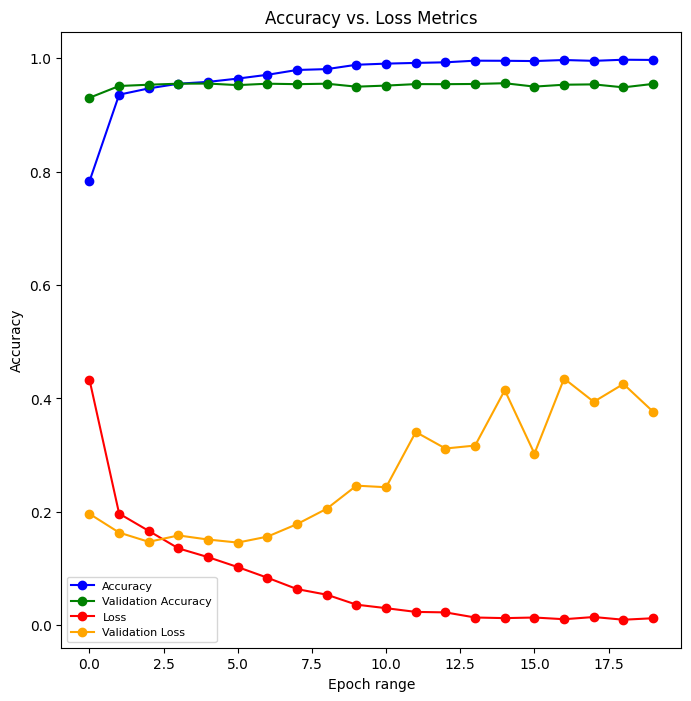

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, '-o', color='blue', label='Accuracy')
plt.plot(epochs_range, val_acc, '-o', color='green', label='Validation Accuracy')
plt.plot(epochs_range, loss, '-o', color='red', label='Loss')
plt.plot(epochs_range, val_loss, '-o', color='orange', label='Validation Loss')
plt.xlabel('Epoch range')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Loss Metrics')
plt.legend(loc='lower left', prop={'size': 8})
plt.show()

Sign of validation loss increasing, which means model is likely overfitting

### Testing Predictions Manually

In [ ]:
try:
    testing_image1 = cv2.imread(os.path.join('manual_test_images', 'testing_image1.png'))
    testing_image2 = cv2.imread(os.path.join('manual_test_images', 'testing_image2.png'))
    testing_image1 = tf.image.resize(testing_image1, (100, 100))
    testing_image2 = tf.image.resize(testing_image2, (100, 100))
except:
    print('Error')

testing_image1 = np.expand_dims(testing_image1, axis=0)
testing_image2 = np.expand_dims(testing_image2, axis=0)

In [16]:
model = tf.keras.models.load_model('../../Dependencies/model_information/models/model_Keras_sequential_v2.h5')

test_image = cv2.imread('../../Dependencies/malaria/malaria-nih/nih-malaria/uninfected/C100P61ThinF_IMG_20150918_144104_cell_128.png')
test_image2 = cv2.imread('../../Dependencies/malaria/malaria-nih/nih-malaria/parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png')

test_image = cv2.resize(test_image, (100, 100))
test_image2 = cv2.resize(test_image2, (100, 100))

test_image = np.expand_dims(test_image, axis=0)
test_image2 = np.expand_dims(test_image2, axis=0)


predict = model.predict(test_image)
predict2 = model.predict(test_image2)
print(predict, predict2)

1/1 [==============================] - 0s 25ms/step
[[0.58519393]] [[0.58519393]]


### Saving the ML model

Depending on which model we decide to use, we can ammend the name of the model for clarity and save it to load at a later stage

In [ ]:
# model.save(os.path.join('model_information/models/', 'model_Keras_sequential.h5'))

# Classifier metrics testing

### VGG Evaluation

In [5]:
import numpy as np
from sklearn.metrics import f1_score
from keras.preprocessing.image import ImageDataGenerator


batchesNUM = 32
vgg_data = "../../Dependencies/malaria/malaria-nih/vgg"

model = tf.keras.models.load_model('../../Dependencies/model_information/models/VGG16_model.h5')
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(vgg_data, target_size = (224, 224), batch_size = batchesNUM, class_mode='categorical')


# get true labels
true_labels = []
for i in range(len(test_set)):
    _, labels = test_set[i]
    true_labels.extend(np.argmax(labels, axis=1))

# get predicted labels
predicted_labels = []
for i in range(len(test_set)):
    images, _ = test_set[i]
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

# calculate f1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f1)

Found 15000 images belonging to 2 classes.
1/1 [==============================] - 3s 3s/step
0.9270381373104472


### Evaluating model results on testing batch

### VGG Accuracy, recall, precision

In [6]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, average_precision_score, f1_score, confusion_matrix

model = tf.keras.models.load_model('../../Dependencies/model_information/models/VGG16_model.h5')
y_true = vgg_test_labels
# Assuming that you have loaded your VGG16 model as `model` and have the true labels in `y_true`
y_pred = model.predict(vgg_test_set) # X is your input data

# Convert the predicted probabilities to predicted class labels (0 or 1)
y_pred = np.argmax(y_pred, axis=1)

# Calculate accuracy, recall, and precision
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
confusion_matrix = confusion_matrix(y_true, y_pred)

# Calculate average precision score (for binary classification)
avg_precision = average_precision_score(y_true, y_pred)

print('Accuracy: ', accuracy)
print('Recall: ', recall)
print('Precision: ', precision)
print('Average Precision: ', avg_precision)

469/469 [==============================] - 43s 90ms/step
Accuracy:  0.9258
Recall:  0.9028
Precision:  0.9846220961936961
Average Precision:  0.9537168284436689


### Keras Sequential evaluation

In [6]:
import tensorflow as tf, sys

# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.BinaryAccuracy()

model = tf.keras.models.load_model('../../Dependencies/model_information/models/model_Keras_sequential_v2.h5')

print('-'*20)
print('Predictions on validation data')
print('-'*20)

for batch in testing_data.as_numpy_iterator():
    try:
        x, y_true = batch
        y_pred = model.predict(x)
        y_pred_class = tf.round(y_pred)
        precision.update_state(y_true, y_pred_class)
        recall.update_state(y_true, y_pred_class)
        accuracy.update_state(y_true, y_pred_class)
        f1 = f1_score(y_true, y_pred_class)
    except Exception as e:
        print('Error:', e)
        break

print('Average Precision Score:', average_precision_score(y_true, y_pred))
print('Recall:', recall.result().numpy())
print('Precision:', precision.result().numpy())
print('F1 Score:', f1)
print('Accuracy:', accuracy.result().numpy())


--------------------
Predictions on validation data
--------------------
1/1 [==============================] - 0s 50ms/step
Average Precision Score: 1.0
Recall: 0.9825545
Precision: 0.9795031
F1 Score: 1.0
Accuracy: 0.9809375


### McNemar's test

- Run on a test set of 5000 images from NIH malaria dataset (VGG testing data)
- NIH data has a testing set of 3,200

In [7]:
from sklearn.metrics import confusion_matrix
import numpy as np

def calculate_mcnemar_statistic(model1, model2, dataset):
    y_true = []
    y_pred1 = []
    y_pred2 = []
    for batch in dataset:
        x, y = batch
        y_true.extend(y)
        y_pred1.extend(np.argmax(model1.predict(x), axis=1))
        y_pred2.extend(np.argmax(model2.predict(x), axis=1))
    cm1 = confusion_matrix(y_true, y_pred1)
    cm2 = confusion_matrix(y_true, y_pred2)
    n = np.sum(cm1)
    # Calculate the McNemar statistic
    denominator = (cm1 + cm2)
    denominator[denominator == 0] = 1e-6
    statistic = ((cm1 - cm2)**2) / denominator
    statistic = np.sum(statistic)
    return statistic, n

model1 = tf.keras.models.load_model('../../Dependencies/model_information/models/model_Keras_sequential_v2.h5')
model2 = tf.keras.models.load_model('../../Dependencies/model_information/models/model_Keras_sequential.h5')
dataset = testing_data
print(calculate_mcnemar_statistic(model1, model2, dataset))

1/1 [==============================] - 0s 22ms/step
(nan, 3200)


C:\Users\Tom\AppData\Local\Temp\ipykernel_3360\1887409689.py:19: RuntimeWarning: invalid value encountered in divide
  statistic = ((cm1 - cm2)**2) / denominator


### Test For Plant Cell Library datasets

### Unknown Database

In [28]:
import cv2
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# load model
keras_model = tf.keras.models.load_model('../../Dependencies/model_information/models/model_Keras_sequential.h5')
model_spatial = tf.keras.models.load_model('../../Dependencies/model_information/models/model_Keras_sequential_v2.h5')
vgg16 = tf.keras.models.load_model('../../Dependencies/model_information/models/VGG16_model.h5')

image1 = cv2.imread("../../Dependencies/malaria/test-dataset/6020.jpg")
image2 = cv2.imread("../../Dependencies/malaria/test-dataset/6021.jpg")
image3 = cv2.imread("../../Dependencies/malaria/test-dataset/6022.jpg")

keras_im = cv2.resize(image1, (100, 100))
keras_im2 = cv2.resize(image2, (100, 100))
keras_im3 = cv2.resize(image3, (100, 100))

vgg_im = cv2.resize(image1, (224, 224))
vgg_im2 = cv2.resize(image2, (224, 224))
vgg_im3 = cv2.resize(image3, (224, 224))

keras_im = np.expand_dims(keras_im, axis=0)
keras_im2 = np.expand_dims(keras_im2, axis=0)
keras_im3 = np.expand_dims(keras_im3, axis=0)
vgg_im = np.expand_dims(vgg_im, axis=0)
vgg_im2 = np.expand_dims(vgg_im2, axis=0)
vgg_im3 = np.expand_dims(vgg_im3, axis=0)

print("keras og model predictions:")

print(keras_model.predict(keras_im))
print(keras_model.predict(keras_im2))
print(keras_model.predict(keras_im3))

print("=====================================")
print("keras spatial model predictions:")

print(model_spatial.predict(keras_im))
print(model_spatial.predict(keras_im2))
print(model_spatial.predict(keras_im3))

print("=====================================")

print("vgg16 model predictions:")

print(vgg16.predict(vgg_im))
print(vgg16.predict(vgg_im2))
print(vgg16.predict(vgg_im3)) 

print("=====================================")

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_test = x_test.astype('float32') / 255.0
x_test_rgb = np.zeros((x_test.shape[0], 100, 100, 3), dtype=np.uint8)
x_test_rgb_vgg = np.zeros((x_test.shape[0], 224, 224, 3), dtype=np.uint8)
for i in range(x_test.shape[0]):
    img_gray = cv2.resize(x_test[i], (100, 100))
    img_vgg = cv2.resize(x_test[i], (224, 224))
    x_test_rgb[i,:,:,0] = img_gray
    x_test_rgb[i,:,:,1] = img_gray
    x_test_rgb[i,:,:,2] = img_gray
    x_test_rgb_vgg[i,:,:,0] = img_vgg
    x_test_rgb_vgg[i,:,:,1] = img_vgg
    x_test_rgb_vgg[i,:,:,2] = img_vgg
    

# Load the trained model
# Make predictions
y_pred = keras_model.predict(x_test_rgb)
y_pred2 = model_spatial.predict(x_test_rgb)

vgg_pre = vgg16.predict(x_test_rgb_vgg)

# Convert the predictions from one-hot encoding to integers
y_pred_int = np.argmax(y_pred, axis=1)
y_pred_int2 = np.argmax(y_pred2, axis=1)
vgg_pred = np.argmax(vgg_pre, axis=1)

# Print the accuracy
acc = np.sum(y_pred_int == y_test) / len(y_test)
acc2 = np.sum(y_pred_int2 == y_test) / len(y_test)
acc3 = np.sum(vgg_pred == y_test) / len(y_test)
print("Accuracy of first keras:", acc)
print("Accuracy of second keras:", acc2)
print("Accuracy of vgg16:", acc3)


keras og model predictions:
1/1 [==============================] - 0s 64ms/step
[[0.]]
1/1 [==============================] - 0s 18ms/step
[[0.]]
1/1 [==============================] - 0s 19ms/step
[[0.]]
keras spatial model predictions:
1/1 [==============================] - 0s 88ms/step
[[9.700243e-17]]
1/1 [==============================] - 0s 23ms/step
[[0.5848045]]
1/1 [==============================] - 0s 24ms/step
[[0.5851939]]
vgg16 model predictions:
1/1 [==============================] - 0s 195ms/step
[[0. 1.]]
1/1 [==============================] - 0s 102ms/step
[[0. 1.]]
1/1 [==============================] - 0s 99ms/step
[[0. 1.]]
313/313 [==============================] - 821s 3s/step
Accuracy of first keras: 0.098
Accuracy of second keras: 0.098
Accuracy of vgg16: 0.1137
